### Instalando librerias

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from keras.utils import to_categorical
import keras

from keras.models import Sequential
from keras.layers import Dense, Convolution1D, MaxPool1D, Flatten, Dropout
from keras.layers import Input
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
tf.__version__

'2.2.0'

### Lectura de datos csv

In [81]:
train_df=pd.read_csv('../data/mitbih_train.csv',header=None)
test_df=pd.read_csv('../data/mitbih_test.csv',header=None)

In [82]:
train_df.shape

(87554, 188)

### Preprocesamiento

In [83]:
test_df = pd.concat([test_df[test_df[187]==0], test_df[test_df[187]==1], test_df[test_df[187]==2], test_df[test_df[187]==3]])

test_df = test_df.sample(frac=1).reset_index(drop=True)

In [84]:
n_test = len(test_df)
spliting = int(n_test * 0.333)

val_df = test_df.iloc[:spliting]
test_df = test_df.iloc[spliting:]

In [85]:
print("Latidos normales", len(train_df[train_df[187]==0]))
print("S", len(train_df[train_df[187]==1]))
print("V", len(train_df[train_df[187]==2]))
print("F", len(train_df[train_df[187]==3]))

n = len(train_df[train_df[187]==1]) + len(train_df[train_df[187]==2]) + len(train_df[train_df[187]==3])

print("Suma:", n)

print("Total:", len(train_df[train_df[187]==0]))
r = n * 70 / 30
print("Recortando:", r)

Latidos normales 72471
S 2223
V 5788
F 641
Suma: 8652
Total: 72471
Recortando: 20188.0


In [86]:
df_0=train_df[train_df[187]==0].iloc[:int(r)]
train_df=pd.concat([df_0,train_df[train_df[187]==1],train_df[train_df[187]==2],train_df[train_df[187]==3]])

### Shaping

In [87]:
target_train = train_df[187]
target_val = val_df[187]
target_test = test_df[187]

y_train = to_categorical(target_train)
y_test = to_categorical(target_test)
y_val = to_categorical(target_val)

In [88]:
len(y_test)

13530

In [89]:
X_train=train_df.iloc[:,:186].values
X_test=test_df.iloc[:,:186].values
X_val=val_df.iloc[:,:186].values

# print('Antes del reshaping: ', X_train.shape)

X_train = X_train.reshape(len(X_train), X_train.shape[1],1)
X_test = X_test.reshape(len(X_test), X_test.shape[1],1)
X_val = X_val.reshape(len(X_val), X_val.shape[1],1)

print('Despues del reshaping: ')
print(f'X_train: {X_train.shape}')
print(f'X_test: {X_test.shape}')
print(f'X_val: {X_val.shape}')

Despues del reshaping: 
X_train: (28840, 186, 1)
X_test: (13530, 186, 1)
X_val: (6754, 186, 1)


### Modelo

In [90]:
model = Sequential()

model.add(Convolution1D(32, (6), activation='relu', input_shape=(X_train.shape[1],1)))
model.add(BatchNormalization())
model.add(MaxPool1D(pool_size=(3), strides=(2), padding="same"))

model.add(Convolution1D(32, (3), activation='relu', input_shape=(X_train.shape[1],1)))
model.add(BatchNormalization())
model.add(MaxPool1D(pool_size=(2), strides=(2), padding="same"))

model.add(Convolution1D(32, (3), activation='relu', input_shape=(X_train.shape[1],1)))
model.add(BatchNormalization())
model.add(MaxPool1D(pool_size=(2), strides=(2), padding="same"))

model.add(Flatten())

model.add(Dense(4, activation='softmax', name='main_output'))

model.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['accuracy'])

callbacks = [EarlyStopping(monitor='val_loss', patience=8),
                 ModelCheckpoint(filepath='conv_model_702010.h5', monitor='val_loss', save_best_only=True)]

history=model.fit(X_train, y_train,epochs=40,callbacks=callbacks, batch_size=256,validation_data=(X_val,y_val))

Epoch 1/40
113/113 [==============================] - 15s 136ms/step - loss: 0.3869 - accuracy: 0.8787 - val_loss: 2.5001 - val_accuracy: 0.0503
Epoch 2/40
113/113 [==============================] - 16s 140ms/step - loss: 0.2206 - accuracy: 0.9346 - val_loss: 2.9450 - val_accuracy: 0.0877
Epoch 3/40
113/113 [==============================] - 15s 129ms/step - loss: 0.1808 - accuracy: 0.9443 - val_loss: 2.2193 - val_accuracy: 0.0927
Epoch 4/40
113/113 [==============================] - 14s 126ms/step - loss: 0.1587 - accuracy: 0.9497 - val_loss: 1.7762 - val_accuracy: 0.1435
Epoch 5/40
113/113 [==============================] - 14s 123ms/step - loss: 0.1430 - accuracy: 0.9547 - val_loss: 0.7075 - val_accuracy: 0.6954
Epoch 6/40
113/113 [==============================] - 14s 126ms/step - loss: 0.1307 - accuracy: 0.9594 - val_loss: 0.2431 - val_accuracy: 0.9257
Epoch 7/40
113/113 [==============================] - 14s 127ms/step - loss: 0.1237 - accuracy: 0.9608 - val_loss: 0.1346 - val_ac

### Ploting results

In [91]:
def evaluate_model(history,X_test,y_test,model):
    scores = model.evaluate((X_test),y_test, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1]*100))
    
    print(history)
    fig1, ax_acc = plt.subplots()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model - Accuracy')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()
    
    fig2, ax_loss = plt.subplots()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model- Loss')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.show()
    target_names=['0','1','2','3','4']
    
    y_true=[]
    for element in y_test:
        y_true.append(np.argmax(element))
    prediction_proba=model.predict(X_test)
    prediction=np.argmax(prediction_proba,axis=1)
    cnf_matrix = confusion_matrix(y_true, prediction)

Accuracy: 95.62%


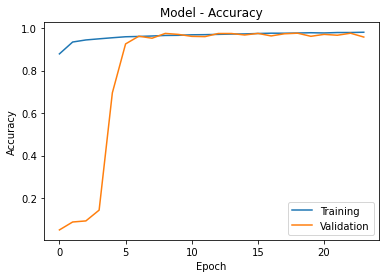

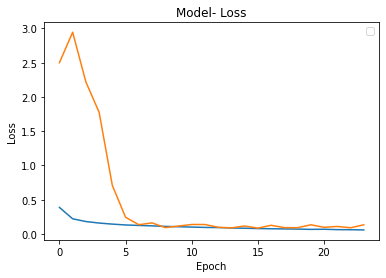

In [92]:
evaluate_model(history,X_test,y_test,model)
y_pred=model.predict(X_test)

In [93]:
# model_name = 'best_model.h5'
# model = keras.models.load_model(f'../model/{model_name}')

y_pred = model.predict(X_test)
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_21 (Conv1D)           (None, 181, 32)           224       
_________________________________________________________________
batch_normalization_21 (Batc (None, 181, 32)           128       
_________________________________________________________________
max_pooling1d_21 (MaxPooling (None, 91, 32)            0         
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 89, 32)            3104      
_________________________________________________________________
batch_normalization_22 (Batc (None, 89, 32)            128       
_________________________________________________________________
max_pooling1d_22 (MaxPooling (None, 45, 32)            0         
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 43, 32)           

In [94]:
def get_max_index_list(x):
    return [np.where(i == np.amax(i))[0][0] for i in x]

In [96]:
y_test_list = get_max_index_list(y_test)
y_pred_list = get_max_index_list(y_pred)

print("Precision", precision_score(y_test_list, y_pred_list, average='micro'))
print("Recall", recall_score(y_test_list, y_pred_list, average='micro'))
print("f1_score", f1_score(y_test_list, y_pred_list, average='micro'))

Precision 0.9562453806356246
Recall 0.9562453806356246
f1_score 0.9562453806356246


### Confusion matrix

Normalized confusion matrix


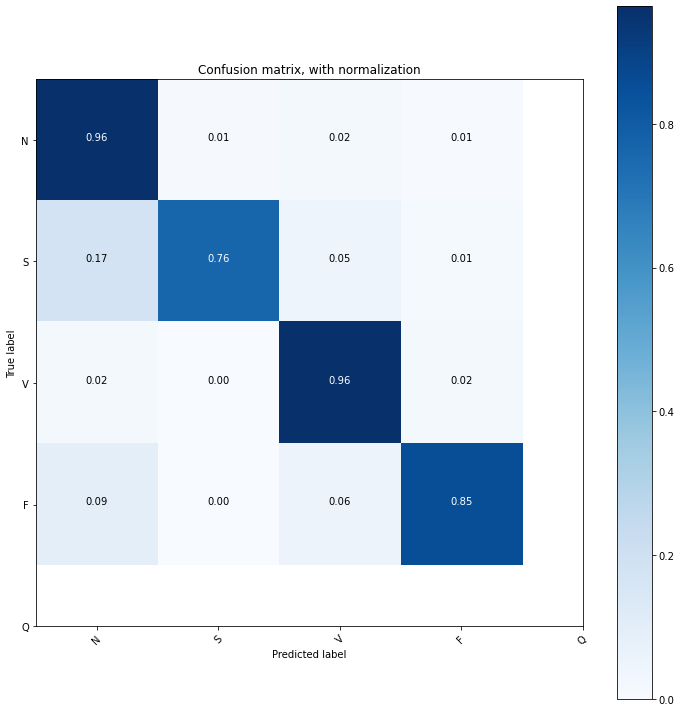

In [97]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=['N', 'S', 'V', 'F', 'Q'],normalize=True,
                      title='Confusion matrix, with normalization')
plt.show()